## Imports

In [1]:
import os
import io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from PIL import Image

from scipy.ndimage import gaussian_filter, median_filter, uniform_filter, sobel, rotate, zoom
from scipy.signal import find_peaks, convolve2d
import scipy.misc

from skimage import filters, restoration, util

from netCDF4 import Dataset
import blend_modes

import cmocean
from colorspacious import cspace_convert

import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

try:
    from jupyterthemes import jtplot
    jtplot.style(theme='onedork')
except ImportError:
    pass

## Function definitions

In [2]:
# Define convenience functions

# Given two masked images and their mask, return an averaged image


def average_from_masks(region1, region2, mask):
    sum1, sum2 = np.sum(region1), np.sum(region2)
    count1, count2 = np.count_nonzero(region1), np.count_nonzero(region2)
    avg1, avg2 = sum1/count1, sum2/count2

    return avg1 * mask + avg2 * ~mask

def combine_phase_and_contrast(phase, contrast):
    # Set up the colormap
    cmap = create_ciecam02_cmap();

    # Use CIECAM02 color map, convert to sRGB1 (to facilitate intensity adjustment)
    im = cmap(contrast / (2 * np.pi));
    im_srgb = im[:, :, :3]
    im_adjusted = np.zeros_like(im_srgb)

    # Apply phase intensity mask to the contrast: low intensity -> dark, high intensity -> light
    for i in range(3):
        im_adjusted[:,:,i] = np.multiply(im_srgb[:,:,i], phase)
        
    return im_adjusted

# Create a perceptually uniform colormap based on CIECAM02.
# Based on https://stackoverflow.com/questions/23712207/cyclic-colormap-without-visual-distortions-for-use-in-phase-angle-plots

def create_ciecam02_cmap():
    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256, 3)) * 60
    color_circle[:,1] = np.ones((256)) * 45
    color_circle[:,2] = np.arange(0, 360, 360 / 256)
    color_circle_rgb = cspace_convert(color_circle, 'JCh', 'sRGB1')

    return mpl.colors.ListedColormap(color_circle_rgb)

# Create a gradient image for removing imaging artifacts. Use strength to tweak effect.
# strength = 0 -> no effect; strength = 1 -> compress range

def create_gradient(image, left=1, right=1, midpoint=0.5, angle=0):
    # Find darkest and lightest values in image
    dark, light = np.min(image), np.max(image)
    l, r = left * dark, right * light
    
    # Get the starting shape and convert the angle to radians
    xd, yd = image.shape
    
    angle = angle if angle >= 0 else 360 + angle
    theta = (angle * np.pi / 180) % (np.pi / 2)

    # Calculate the size of the bounding box: this is the size needed for the gradient
    xx = int(xd * np.cos(theta) + 2 * yd * np.sin(theta))
    yy = int(yd * np.cos(theta) + 2 * xd * np.sin(theta))
    sep = int(xx * midpoint)

    # ...and calculate the size of the bounding box for the above once rotated
    xxx = int(xx * np.cos(theta) + yy * np.sin(theta))
    yyy = int(yy * np.cos(theta) + xx * np.sin(theta))

    # Calculate the offsets for the box to crop out
    lr = (xxx - xd) // 2
    tb = (yyy - yd) // 2

    width = xxx - 2 * lr
    height = yyy - 2 * tb

    # Create the gradient
    left_gradient = np.linspace(l, 0, sep)
    right_gradient = np.linspace(0, r, xx - sep)
    gradient = np.tile(np.concatenate([left_gradient, right_gradient]), (yy, 1))
    gradient = rotate(gradient, angle)
    gradient = gradient[lr:xxx - lr, tb:yyy - tb]
    
    # And handle rounding errors
    gradient = zoom(gradient, (xd / width, yd / height))

    return gradient


def create_gradient_orig(image, dark=1, light=1, angle=0):
    # Get the starting shape and convert the angle to radians
    xd, yd = image.shape
    
    angle = angle if angle >= 0 else 360 + angle
    theta = (angle * np.pi / 180) % (np.pi / 2)

    # Calculate the size of the bounding box: this is the size needed for the gradient
    xx = int(xd * np.cos(theta) + 2 * yd * np.sin(theta))
    yy = int(yd * np.cos(theta) + 2 * xd * np.sin(theta))

    # ...and calculate the size of the bounding box for the above rotated
    xxx = int(xx * np.cos(theta) + yy * np.sin(theta))
    yyy = int(yy * np.cos(theta) + xx * np.sin(theta))

    # Calculate the offsets for the box to crop out
    lr = (xxx - xd) // 2
    tb = (yyy - yd) // 2

    width = xxx - 2 * lr
    height = yyy - 2 * tb

    # Get the darkest values from the left (based on observation); brightest, right
    dark = np.min(image[:, :4]) * dark
    light = np.max(image[:, -5:]) / light

    # Create the gradient
    gradient = np.tile(np.linspace(dark, light, xx), (yy, 1))
    gradient = rotate(gradient, angle)
    gradient = gradient[lr:xxx - lr, tb:yyy - tb]
    
    # And handle rounding errors
    gradient = zoom(gradient, (xd / width, yd / height))

    return gradient

# Segment an image into regions.
# Based on code at https://scipy-lectures.org/advanced/image_processing/


def find_segments(data, bins=60):
    # The segments will be calculated using an index multiplied by step size added to the minimum
    data_min = data.min()
    step = np.ptp(data) / bins

    # Segregate bright vs. dark
    mask = (data > data.mean()).astype(float)
    #mask += 0.1 * data
    img = mask + 0.2 * np.random.randn(*mask.shape)

    hist, bin_edges = np.histogram(img, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return [data_min + i * step for i in find_peaks(hist)[0] if hist[i] > 0.5 * hist.max()]


def find_weighted_average(data, bins=100, prom=0.2):
    hist, bin_edges = np.histogram(data, bins=bins)

    peaks = find_peaks(hist, prominence=prom * np.max(hist))[0]
    relevant_peaks = np.asarray([(b, h)
                                 for b, h in zip(bin_edges[peaks], hist[peaks])])

    weighted_average = np.sum(
        relevant_peaks[:, 0] * relevant_peaks[:, 1]) / np.sum(relevant_peaks[:, 1])

    return relevant_peaks, weighted_average

# Return combined x and y contrast

def get_contrast(im_x, im_y):
    contrast = np.array([np.arctan2(y, x) for x, y in zip(im_x, im_y)])

    # arctan2 works over the range -pi to pi; shift everything to 0 to 2pi for color mapping
    contrast_adjusted = contrast.ravel()
    for i in range(len(contrast_adjusted)):
        value = contrast_adjusted[i]
        positive = value >= 0
        contrast_adjusted[i] = value if positive else value + 2 * np.pi

    return contrast_adjusted.reshape(contrast.shape)


# Get H and S values given an array of angles in degrees


def get_hue_and_saturation_values(angles):
    r_to_y = [[255, s] for s in range(256)]
    y_to_g = [[h, 255] for h in range(254, -1, -1)]
    g_to_b = [[0, s] for s in range(254, -1, -1)]
    b_to_r = [[h, 0] for h in range(255)]

    color_scale = np.asarray(r_to_y + y_to_g + g_to_b + b_to_r, dtype='uint8')
    index = np.multiply(angles, len(color_scale) / 360).astype('uint16')

    hs = color_scale[index][:, :, 0]
    ss = color_scale[index][:, :, 1]

    return hs, ss

# Return an image of intensities: low -> dark, high -> light

def get_phase_intensities(im_x, im_y):
    # Use x and y values to determine magnitude

    phase_intensities = [np.sqrt(x**2 + y**2) for x, y in zip(im_x.ravel(), im_y.ravel())]
    phase_intensities /= np.max(phase_intensities)
    return phase_intensities.reshape(im_x.shape)

# Determine the size of a single pixel in the input image

def get_scale(image):
    full_scale = np.abs(Dataset(file + imSuffix, 'r').variables['vertical_full_scale'][...].data)
    magnification = np.abs(Dataset(file + imSuffix, 'r').variables['magnification'][...].data)

    adjusted_scale = full_scale / magnification
    return adjusted_scale / image.shape[1]

def get_zeros():
    zero_vars = Dataset(file + imSuffix, 'r').variables
    
    return {
        'ix' : np.abs(zero_vars['ix_counter_zero'][...].data),
        'iy' : np.abs(zero_vars['iy_counter_zero'][...].data),
        'mx' : np.abs(zero_vars['mx_counter_zero'][...].data),
        'my' : np.abs(zero_vars['my_counter_zero'][...].data)
    }

# Read a data file, which is in NetCDF format, and return the image data


def imageData(file):
    return Dataset(file, 'r').variables['image_data']

# Scale the input from 0 to 1


def normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)
    data_range = np.ptp(data)

    return np.array([(i - data_min) / data_range for i in data])


def scale_from_to(scale_from, scale_to):
    from_range = np.ptp(scale_from)
    from_min = np.min(scale_from)
    to_range = np.ptp(scale_to)
    to_min = np.min(scale_to)
    conversion = to_range / from_range

    return to_min + (scale_from - from_min) * conversion


def show_color(h, s, v):
    hs = Image.fromarray(
        np.tile([h] * 100, (100, 1)).astype('uint8')).convert('L')
    ss = Image.fromarray(
        np.tile([h] * 100, (100, 1)).astype('uint8')).convert('L')
    vs = Image.fromarray(np.ones((100, 100)) * v).convert('L')

    fig = plt.figure()

    plt.imshow(Image.merge('HSV', (hs, ss, vs)))

# Plot a 5x5 grid of image removing a gradient controlled by parameters.
# Convolution code influenced by
# https://gis.stackexchange.com/questions/254753/calculate-the-average-of-neighbor-pixels-for-raster-edge


def show_gradients(name, image, left=1, right=1, midpoint=0.5, angle=0):
    # Set up for showing average values below
    s = 5
    kernel = np.ones((s, s))
    #kernel[(s - 1) // 2, (s - 1) // 2] = 0

    xd, yd = image.shape
    points = 16
    X = np.linspace(xd // points, xd, points, False, dtype='uint8')
    Y = np.linspace(xd // points, xd, points, False, dtype='uint8')

    x, y = np.meshgrid(X, Y)
    xs, ys = x.ravel(), y.ravel()
    zippy = zip(xs, ys)
    
    plt.figure(figsize=(15, 5))

    # Show the starting points
    show_subplot_raw(image, 1, 3, 1, name + ' raw')
    ax = plt.subplot(1, 3, 2);
    ax.hist([np.average(image[x - 3:x + 4, y - 3:y + 4]) for x, y in zippy], bins=32)
    show_subplot_raw(create_gradient(image, left, right, midpoint, angle), 1, 3,
                     3, name + ' gradient at {:.1f}°'.format(angle))

    fig, axs = plt.subplots(6, 3, figsize=(15, 30))

    for i in range(3):
        #d = 1 + (dark + i) / 10
        l = (-0.05 + i / 20) + left

        for j in range(3):
            #l = 1 + (light + j) / 10
            r = (-0.05 + j / 20) + right

            ax = axs[2 * i, j]
            #im = image - create_gradient(image, d, l, angle)
            im = image + create_gradient(image, l, r, midpoint, angle)

            show_subplot_raw(im, ax=ax)
            ax.set_title('Left: {:.2f}, right: {:.2f}, midpoint: {:.2f}'.format(l, r, midpoint))

            # Show average values around a grid of points
            #vals = convolve2d(im, kernel, mode='same') / convolve2d(np.ones(im.shape), kernel, mode='same');
            vals = [np.average(im[x - 2:x + 3, y - 2:y + 3]) for x, y in zip (xs, ys)]
            #ax.plot(xs, ys, 'ro')
            #zippy = zip(xs, ys)
            #vals = [np.average(im[x - 3:x + 4, y - 3:y + 4]) for x, y in zippy]
            #[ax.annotate('{:.2f}'.format(vals[x, y]), (x, y),
            #             textcoords='offset points', xytext=(-15, 10), fontsize=14, color='black')
            #    for x, y in zippy]
            
            axs[2 * i + 1, j].hist(vals, bins=32);


# Name says it all...


def show_hsv_colors():
    r_to_y = [[255, s] for s in range(256)]
    y_to_g = [[h, 255] for h in range(254, -1, -1)]
    g_to_b = [[0, s] for s in range(254, -1, -1)]
    b_to_r = [[h, 0] for h in range(255)]

    color_scale = np.asarray(r_to_y + y_to_g + g_to_b + b_to_r, dtype='uint8')

    hs = np.tile(color_scale[:, 0], (100, 1))
    ss = np.tile(color_scale[:, 1], (100, 1))
    vs = np.ones(np.array(hs).shape) * 128

    hs_img = Image.fromarray(hs).convert('L')
    ss_img = Image.fromarray(ss).convert('L')
    vs_img = Image.fromarray(vs).convert('L')

    plt.imshow(Image.merge('HSV', (hs_img, ss_img, vs_img)))
    plt.grid(b=None)
    ax = plt.gca()
    plt.locator_params(axis='x', nbins=5)
    ax.set_xticklabels((0, 0, 90, 180, 270, 360))
    ax.set_yticklabels(())
    plt.xlabel('Angle (°)')
    plt.title('HSV colors by angle')

# Borrowed (very) heavily from
# https://stackoverflow.com/questions/31940285/plot-a-polar-color-wheel-based-on-a-colormap-using-python-matplotlib


def show_hsv_colors_circle(ax=None):
    xs = np.arange(0, 2 * np.pi, 0.01)
    ys = np.ones_like(xs)

    if ax == None:
        plt.figure()
        ax = plt.subplot(1, 1, 1, polar=True)

    ax.scatter(xs, ys, c=xs, s=500, cmap='hsv', vmin=0, vmax=2 * np.pi)
    ax.set_yticks(())
    ax.set_anchor('W')

def show_phase_colors_circle(ax=None):
    xs = np.arange(0, 2 * np.pi, 0.01)
    ys = np.ones_like(xs)

    if ax == None:
        plt.figure()
        ax = plt.subplot(1, 1, 1, polar=True)

    ax.scatter(xs, ys, c=xs, s=500, cmap=create_ciecam02_cmap(), vmin=0, vmax=2 * np.pi)
    ax.set_yticks(())
    ax.set_anchor('W')
    
    
# Also borrowed from the above site


def show_hsv_colors_ring():
    fig = plt.figure()

    display_axes = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')

    # This is a nasty hack - using the hidden field to
    # multiply the values such that 1 become 2*pi
    # this field is supposed to take values 1 or -1 only!!
    display_axes._direction = 2*np.pi
    norm = mpl.colors.Normalize(0.0, 2*np.pi)

    # Plot the colorbar onto the polar axis
    # note - use orientation horizontal so that the gradient goes around
    # the wheel rather than centre out
    quant_steps = 2056
    cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cm.get_cmap('hsv', quant_steps),
                                   norm=norm,
                                   orientation='horizontal')

    # aesthetics - get rid of border and axis labels
    cb.outline.set_visible(False)
    display_axes.set_axis_off()
    display_axes.set_rlim([-1, 1])


def show_subplot(image, rows=1, cols=1, pos=1, title='', vmin=0, vmax=1, ax=None):
    if ax == None:
        ax = plt.subplot(rows, cols, pos)

    ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    ax.grid(False)
    ax.set_title(title)
    
    return ax


def show_subplot_raw(image, rows=1, cols=1, pos=1, title='', ax=None):
    return show_subplot(image, rows, cols, pos, title,
                 vmin=np.min(image), vmax=np.max(image), ax=ax)

# Create a vector plot of the domains

def show_vector_plot(im_x, im_y, ax=None, color='white', scale=2):
    # Get dimensions
    xd, yd = im_x.shape

    X = np.linspace(xd / 32, xd, 32, dtype=np.uint8)
    Y = np.linspace(yd / 32, yd, 32, dtype=np.uint8)

    # Create a pair of (x, y) coordinates
    U, V = np.meshgrid(X, Y)
    x, y = U.ravel(), V.ravel()

    # Pull the values at those coordinates. Had to swap x and y for the plot to orient correctly.
    # No idea why.
    Xs = convolve2d(im_x, np.ones((15, 15)), mode='same')[y, x]
    Ys = convolve2d(im_y, np.ones((15, 15)), mode='same')[y, x]

    if ax == None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)

    # Show the plot
    ax.quiver(x, y, Xs, Ys, angles='uv', scale_units='dots', color=color, scale=scale);

    # Now flip the y axis (quiver puts 0 at the bottom by default)
    #ax.set_ylim(ax.get_ylim()[::-1]);

## Read and view files

In [3]:
# Configure input files

indir = "/Users/rmoraski/Library/Mobile \
Documents/com~apple~CloudDocs/School/Electrons/Mathematica/NISTView-\
ish/"
imSuffix = "_ix.sempa"
mxSuffix = "_mx.sempa"
mySuffix = "_my.sempa"
mzSuffix = "_mz.sempa"

name = "191001_Fe_whisker/Fe_whisker"
run = 2

file = indir + name + f'{run:0>3}'

In [4]:
# Read in image data. Transpose undoes the rotation the NetCDF format causes.

ddt = np.transpose(imageData(file + imSuffix))
nddt = normalize(ddt)
ddx = np.transpose(imageData(file + mxSuffix))
nddx = normalize(ddx)
ddy = np.transpose(imageData(file + mySuffix))
nddy = normalize(ddy)

scale = get_scale(ddt)

print('Intensity - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddt.min(), ddt.max(), np.ptp(ddt)))
print('MX        - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddx.min(), ddx.max(), np.ptp(ddx)))
print('MY        - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddy.min(), ddy.max(), np.ptp(ddy)))

Intensity - min:  538874.44, max: 1208874.50, PtP:  670000.06
MX        - min:       0.64, max:       1.67, PtP:       1.03
MY        - min:      -0.73, max:       0.63, PtP:       1.35


In [31]:
odict = Dataset(file + mxSuffix, 'r').variables
keys = list(odict.keys())
odict

OrderedDict([('horizontal_min', <class 'netCDF4._netCDF4.Variable'>
              float64 horizontal_min()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('horizontal_max', <class 'netCDF4._netCDF4.Variable'>
              float64 horizontal_max()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('vertical_min', <class 'netCDF4._netCDF4.Variable'>
              float64 vertical_min()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('vertical_max', <class 'netCDF4._netCDF4.Variable'>
              float64 vertical_max()
              unlimited dimensions: 
              current shape = ()
              filling on, default _FillValue of 9.969209968386869e+36

In [32]:
get_zeros()

{'ix': 125.53719008264463,
 'iy': 1637.3553719008264,
 'mx': 616895.4545454545,
 'my': 598575.0413223141}

In [33]:
for key in keys[:-1]:
    print('{}: '.format(key))
    print(Dataset(file + mySuffix, 'r').variables[key][...].data)
    print('\n')

horizontal_min: 
0.0


horizontal_max: 
1.0


vertical_min: 
0.0


vertical_max: 
1.0


horizontal_full_scale: 
0.139


vertical_full_scale: 
0.139


magnification: 
1200.0


file_path: 
[b'/' b'h' b'o' b'm' b'e' b'/' b's' b'e' b'm' b'p' b'a' b'/' b'd' b'a'
 b't' b'a' b'/' b'1' b'9' b'1' b'0' b'0' b'1' b'_' b'F' b'e' b'_' b'w'
 b'h' b'i' b's' b'k' b'e' b'r' b'/' b'F' b'e' b'_' b'w' b'h' b'i' b's'
 b'k' b'e' b'r' b'0' b'0' b'2' b'_' b'm' b'y' b'.' b's' b'e' b'm' b'p'
 b'a' b'']


title: 
[b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'']


note: 
[b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'']


sample_id: 
[b'' b'' b'

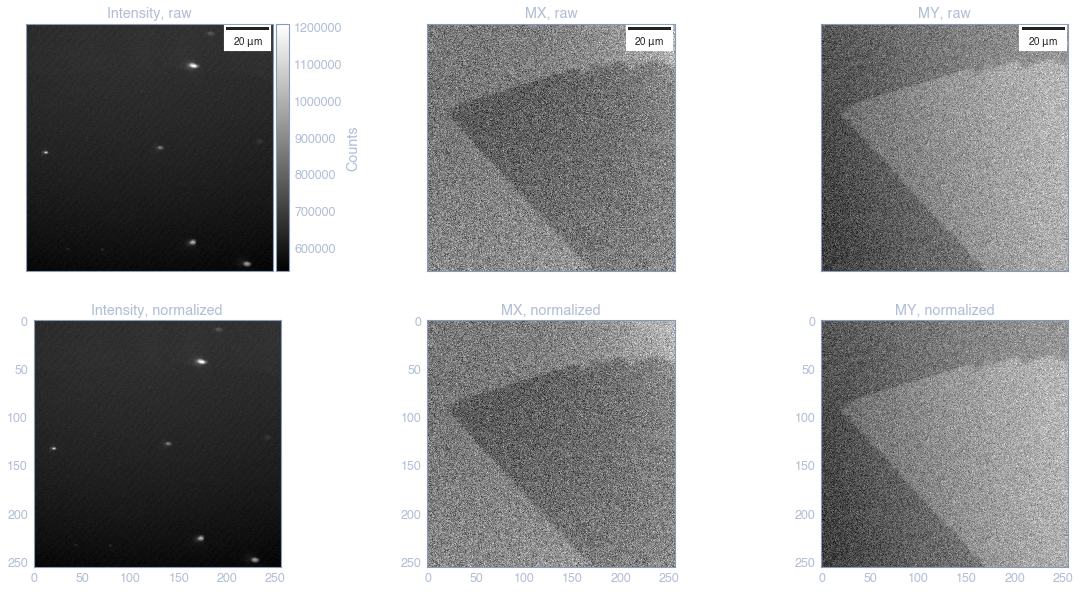

In [5]:
# Have a look at the input files

plt.figure(figsize=(20, 10));

ax1 = show_subplot_raw(ddt, 2, 3, 1, 'Intensity, raw');
ax1.add_artist(ScaleBar(scale));
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# Add a colorbar for counts
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddt.min(), ddt.max()))
divider = make_axes_locatable(ax1);
cax = divider.append_axes('right', size='5%', pad=0.05);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label('Counts')

ax2 = show_subplot_raw(ddx, 2, 3, 2, 'MX, raw');
ax2.add_artist(ScaleBar(scale));
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3 = show_subplot_raw(ddy, 2, 3, 3, 'MY, raw');
ax3.add_artist(ScaleBar(scale));
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

show_subplot(nddt, 2, 3, 4, 'Intensity, normalized');
show_subplot(nddx, 2, 3, 5, 'MX, normalized');
show_subplot(nddy, 2, 3, 6, 'MY, normalized');

In [35]:
ddt = nddt

## Filter intensity image

In [6]:
# Create a Gaussian filter for the intensity image and subtract from the image to minimize gradient issues
# Also try others. Turns out median is best for intensity, gaussian for contrast

ddt_blurred = gaussian_filter(ddt, 3);
ddt_median = median_filter(ddt, 3);
ddt_uniform = uniform_filter(ddt, 3);

ddt_flat = ddt - ddt_blurred;
ddt_flat2 = ddt - ddt_median;
ddt_flat3 = ddt - ddt_uniform;

Gaussian values - min: 553045.38, max:  860853.38, PtP: 307808.00
Median values   - min: 544874.44, max: 1169374.50, PtP: 624500.06
Uniform values  - min: 547041.06, max: 1133652.25, PtP: 586611.19


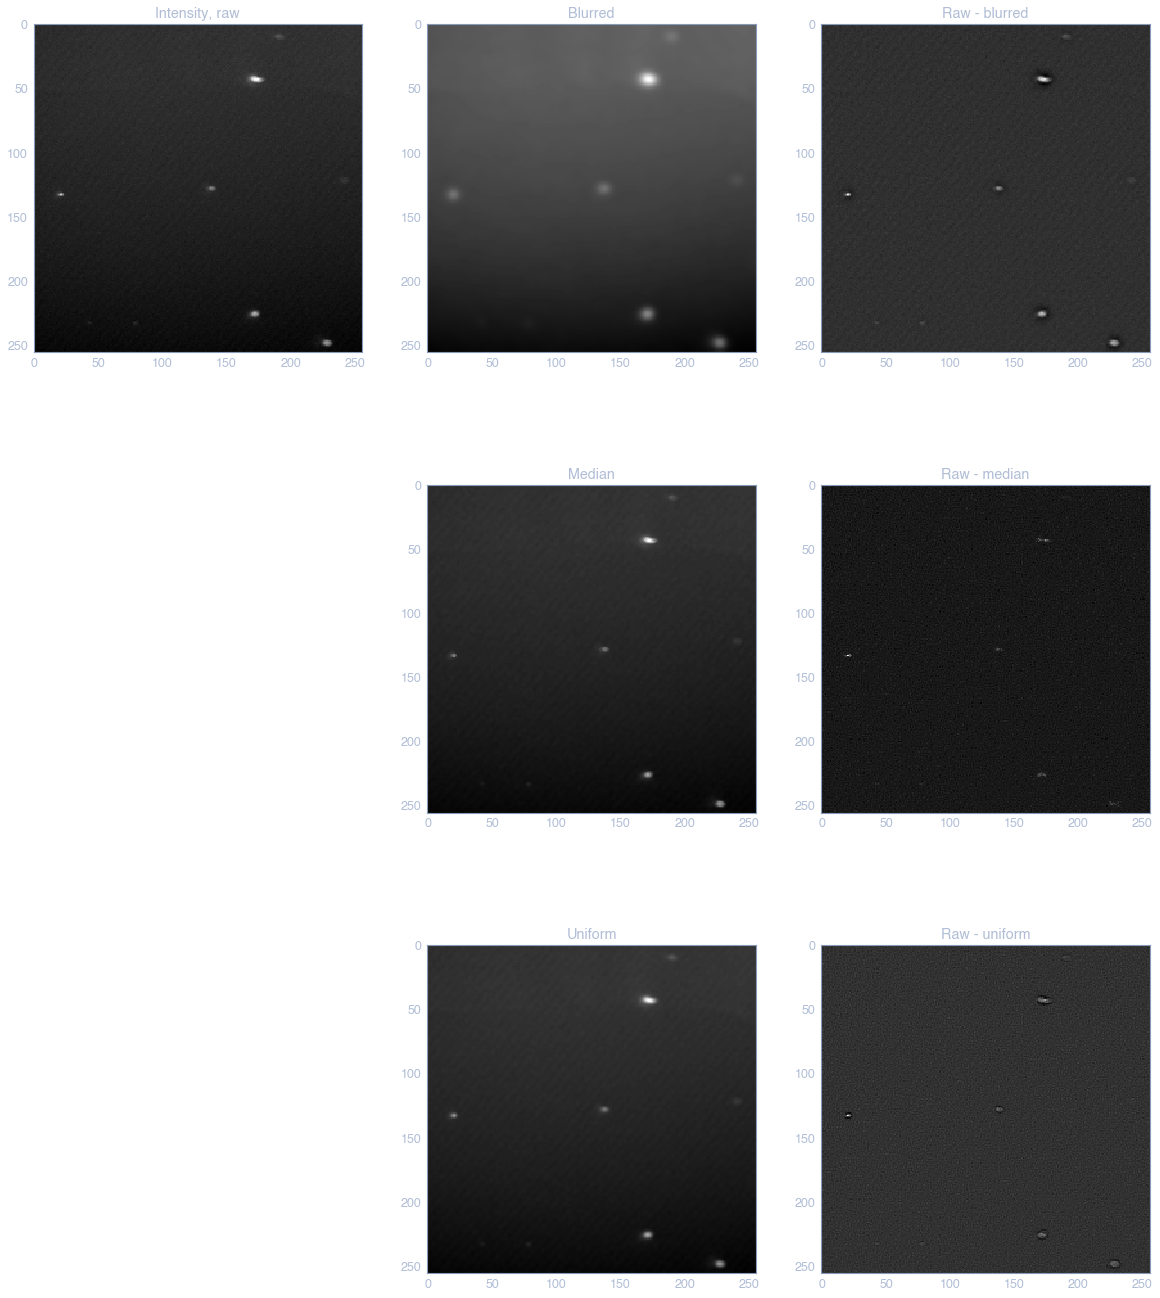

In [7]:
# See if the exposure gradient has been removed

plt.figure(figsize=(20, 24))

show_subplot_raw(ddt, 3, 3, 1, 'Intensity, raw')
show_subplot_raw(ddt_blurred, 3, 3, 2, 'Blurred')
show_subplot_raw(ddt_flat, 3, 3, 3, 'Raw - blurred')
show_subplot_raw(ddt_median, 3, 3, 5, 'Median')
show_subplot_raw(ddt_flat2, 3, 3, 6, 'Raw - median')
show_subplot_raw(ddt_uniform, 3, 3, 8, 'Uniform')
show_subplot_raw(ddt_flat3, 3, 3, 9, 'Raw - uniform')

print('Gaussian values - min: {:.2f}, max: {:10.2f}, PtP: {:.2f}'.format(
    ddt_blurred.min(), ddt_blurred.max(), np.ptp(ddt_blurred)))
print('Median values   - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(
    ddt_median.min(), ddt_median.max(), np.ptp(ddt_median)))
print('Uniform values  - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(
    ddt_uniform.min(), ddt_uniform.max(), np.ptp(ddt_uniform)))

## Filter contrast images

### Remove image gradients (flatten)

MX        - min:       0.64, max:       1.67, PtP:       1.03


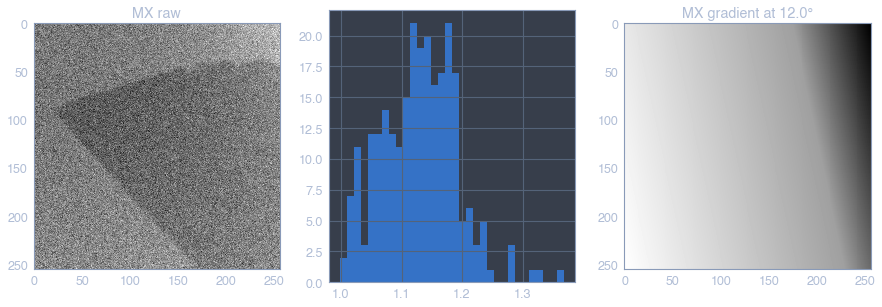

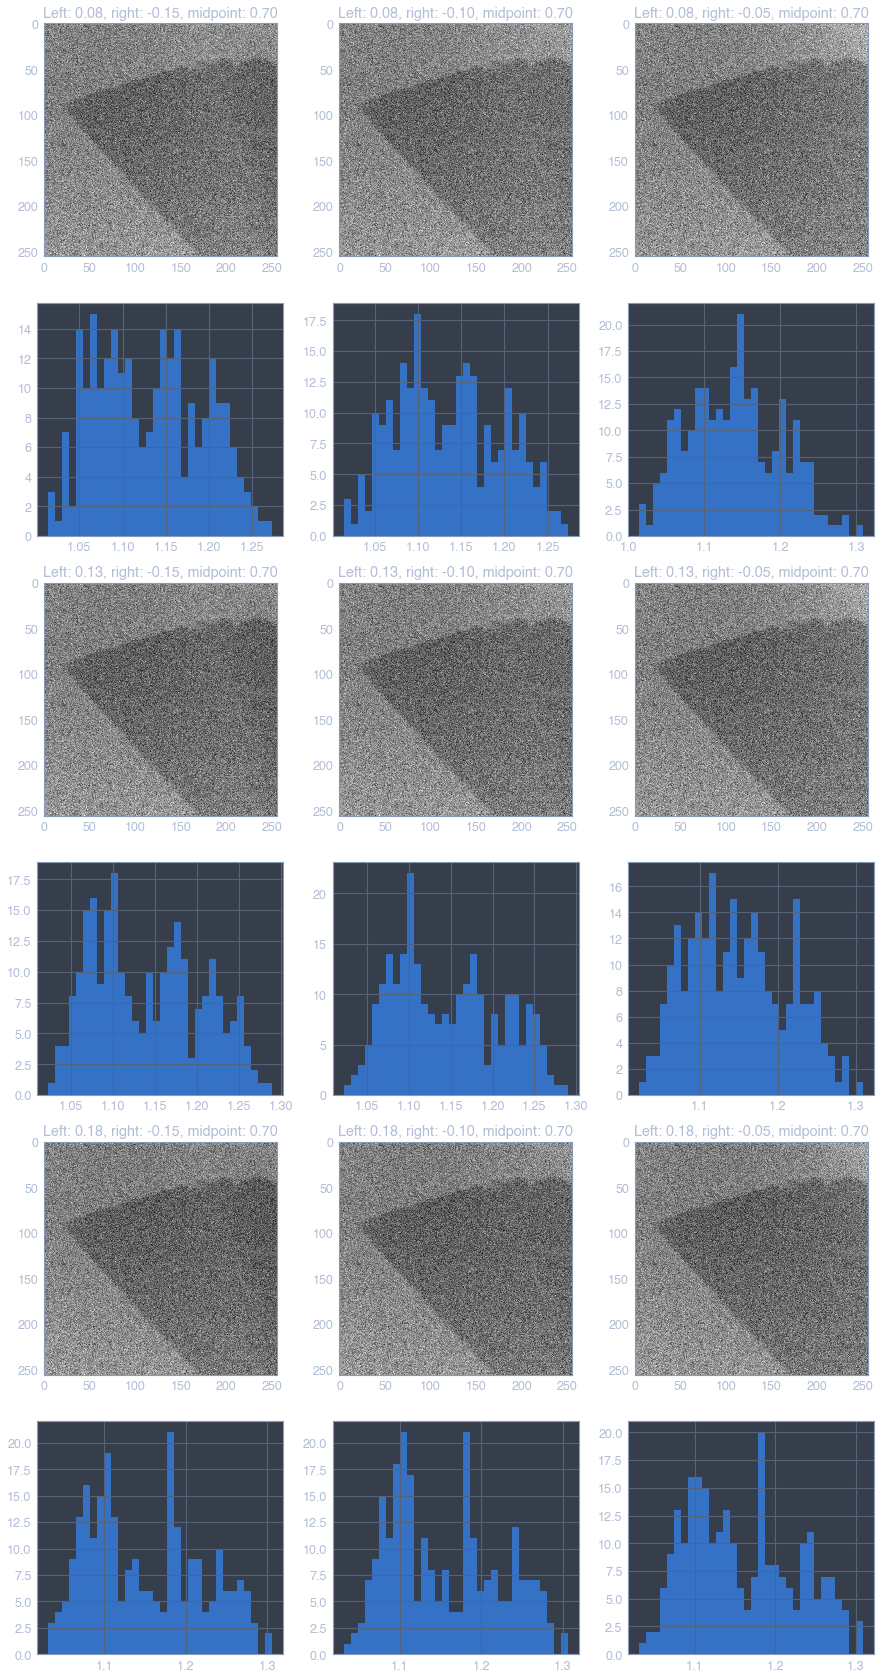

In [8]:
# Find a suitable gradient strength for x

#left, right, midpoint, angle = -0.13, -0.25, 0.75, 40 # run 1
left, right, midpoint, angle = 0.13, -0.1, 0.7, 12 # run 2

show_gradients('MX', ddx, left, right, midpoint, angle)

print('MX        - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddx.min(), ddx.max(), np.ptp(ddx)))

MY        - min:      -0.73, max:       0.63, PtP:       1.35


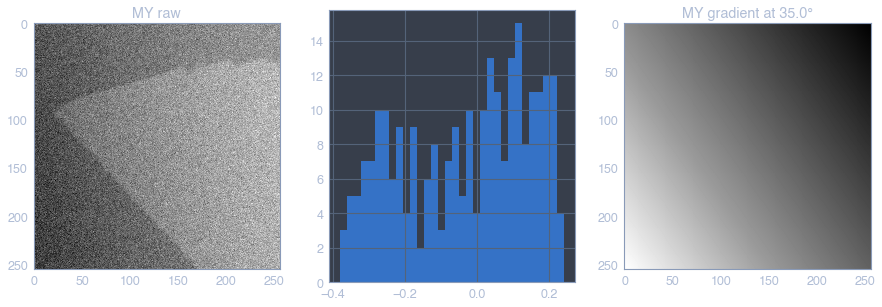

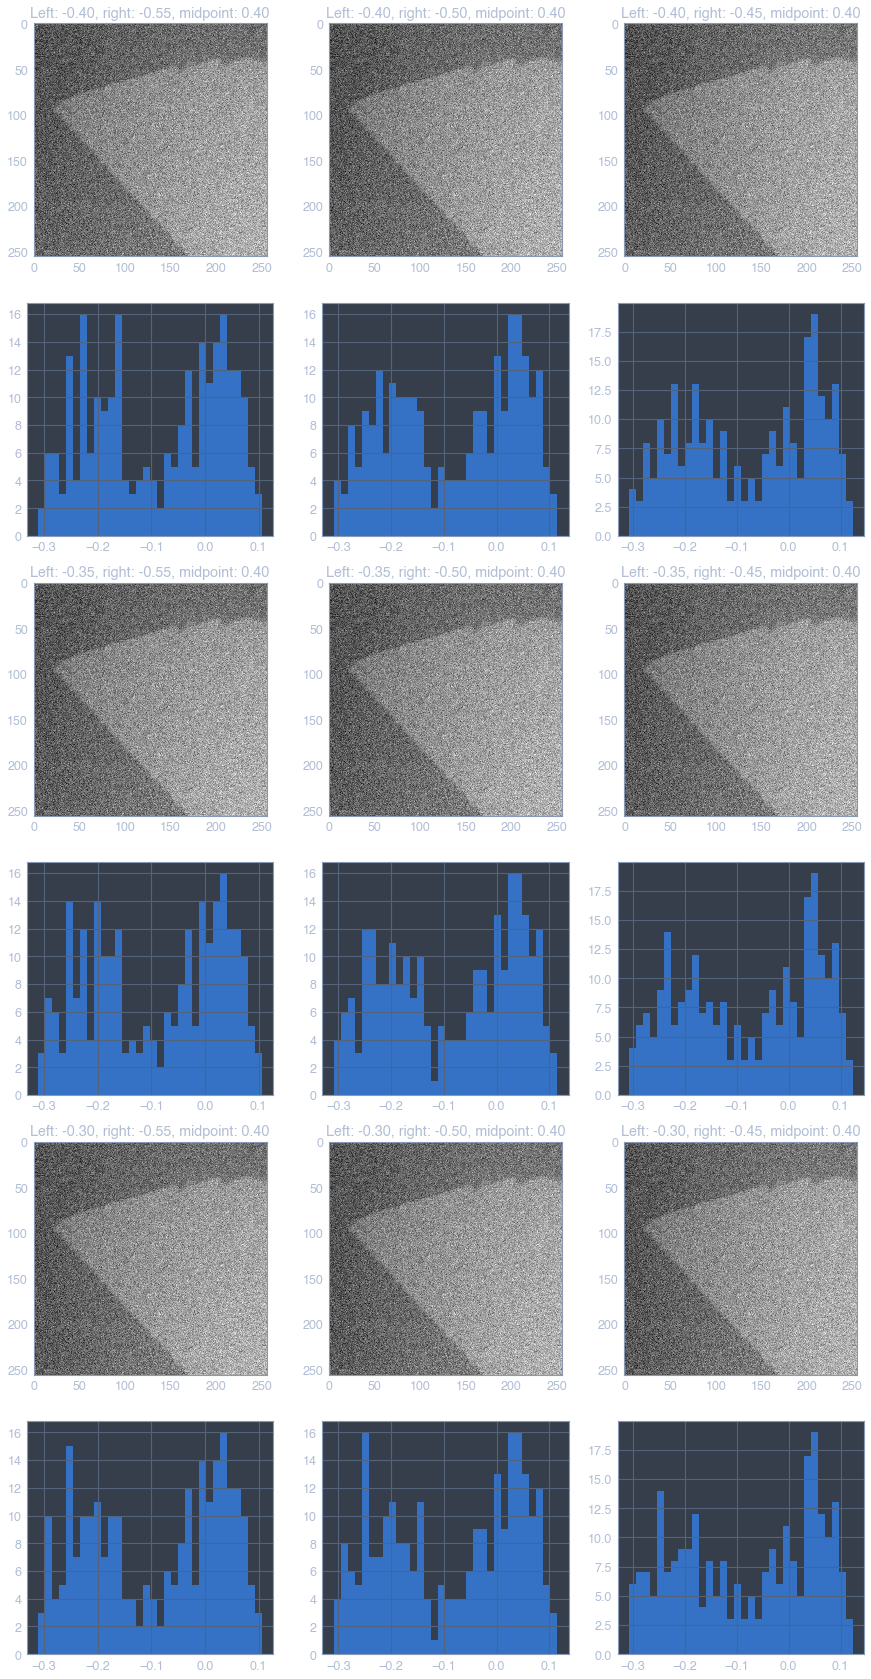

In [9]:
# Find a suitable gradient strength for y

#left, right, midpoint, angle = 0, -0.65, 0.3, 35 # run 1
left, right, midpoint, angle = -0.35, -0.5, 0.4, 35 # run 2

show_gradients('MY', ddy, left, right, midpoint, angle)

print('MY        - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddy.min(), ddy.max(), np.ptp(ddy)))

In [10]:
# Create filters for the contrast images based on best values from above

# run 1
# ddx_gradient = create_gradient(ddx, -0.13, -0.25, 0.55, 40)
# ddy_gradient = create_gradient(ddy, 0, -0.65, 0.3, 35)

# run 2
ddx_gradient = create_gradient(ddx, 0.13, -0.1, 0.7, 12)
ddy_gradient = create_gradient(ddy, -0.35, -0.5, 0.4, 35)

ddx_flat = ddx + ddx_gradient;
ddy_flat = ddy + ddy_gradient;

ddx_avg = np.average(ddx_flat);
ddy_avg = np.average(ddy_flat);

print('MX flat - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddx_flat.min(), ddx_flat.max(), np.ptp(ddx_flat)))
print('MY flat - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddy_flat.min(), ddy_flat.max(), np.ptp(ddy_flat)))

MX flat - min: 0.69, max: 1.67, PtP: 0.98
MY flat - min: -0.65, max: 0.45, PtP: 1.10


### Find offsets

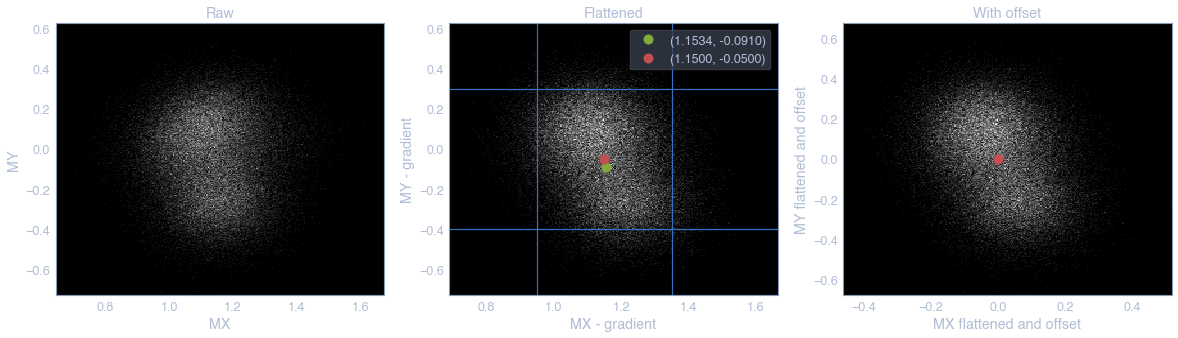

In [13]:
#l, r, t, b = 0.93, 1.35, 0.1, -0.23; # run 1
l, r, t, b = 0.95, 1.35, 0.3, -0.4; # run 2

guess_x, guess_y = (l + r) / 2, (t + b) / 2;

fig = plt.figure(figsize=(20, 5));
ax1 = fig.add_subplot(1, 3, 1);
ax2 = fig.add_subplot(1, 3, 2);
ax3 = fig.add_subplot(1, 3, 3);

ax1.hist2d(ddx.ravel(), ddy.ravel(), bins=256, cmap='gray');
ax1.set_xlabel('MX');
ax1.set_ylabel('MY');
ax1.set_title('Raw');

ax2.hist2d(ddx_flat.ravel(), ddy.ravel(), bins=256, cmap='gray');
ax2.plot(ddx_avg, ddy_avg, 'go', ms=10, label='({:.4f}, {:.4f})'.format(ddx_avg, ddy_avg));
ax2.plot(guess_x, guess_y, 'ro', ms=10, label='({:.4f}, {:.4f})'.format(guess_x, guess_y));
ax2.axvline(l);
ax2.axvline(r);
ax2.axhline(t);
ax2.axhline(b);
ax2.legend();
ax2.set_xlabel('MX - gradient');
ax2.set_ylabel('MY - gradient');
ax2.set_title('Flattened');

ax3.hist2d(ddx_flat.ravel() - guess_x, ddy.ravel() - guess_y, bins=256, cmap='gray');
ax3.plot(0, 0, 'ro', ms=10);
ax3.set_xlabel('MX flattened and offset');
ax3.set_ylabel('MY flattened and offset');
ax3.set_title('With offset');

In [14]:
ddx_flat = ddx_flat - guess_x
ddy_flat = ddy_flat - guess_y

print('MX flat - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    ddx_flat.min(), ddx_flat.max(), np.average(ddx_flat), np.ptp(ddx_flat)))
print('MY flat - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    ddy_flat.min(), ddy_flat.max(), np.average(ddy_flat), np.ptp(ddy_flat)))

MX flat - min: -0.46, max: 0.52, average: 0.00, PtP: 0.98
MY flat - min: -0.60, max: 0.50, average: -0.04, PtP: 1.10


### Denoise

In [15]:
# Try different noise removal approaches

alpha = 30

ddx_denoised = gaussian_filter(ddx_flat, 3);
# ddx_denoised_f = gaussian_filter(ddx_denoised, 1)
# ddx_denoised = ddx_denoised_f + alpha * (ddx_denoised - ddx_denoised_f)
ddy_denoised = gaussian_filter(ddy_flat, 3);

ddx_denoised_median = median_filter(ddx_flat, 25);
ddx_denoised_f = gaussian_filter(ddx_denoised_median, 1)
ddx_denoised_median = ddx_denoised_f + alpha * (ddx_denoised_median - ddx_denoised_f)

ddy_denoised_median = median_filter(ddy_flat, 25);

ddx_denoised_chambolle = restoration.denoise_tv_chambolle(ddx_flat, weight=0.1);
#ddx_denoised_chambolle = restoration.denoise_wavelet(ddx_flat);
ddy_denoised_chambolle = restoration.denoise_tv_chambolle(ddy_flat, weight=0.1);

MX values   - min: 0.64, max: 1.67, PtP: 1.03
MX flat     - min: -0.46, max: 0.52, PtP: 0.98
MX gaussian - min: -0.11, max: 0.15, PtP: 0.26
MX median   - min: -0.18, max: 0.27, PtP: 0.45

MY values   - min: -0.73, max: 0.63, PtP: 1.35
MY flat     - min: -0.60, max: 0.50, PtP: 1.10
MY gaussian - min: -0.28, max: 0.19, PtP: 0.46
MY median   - min: -0.25, max: 0.17, PtP: 0.42


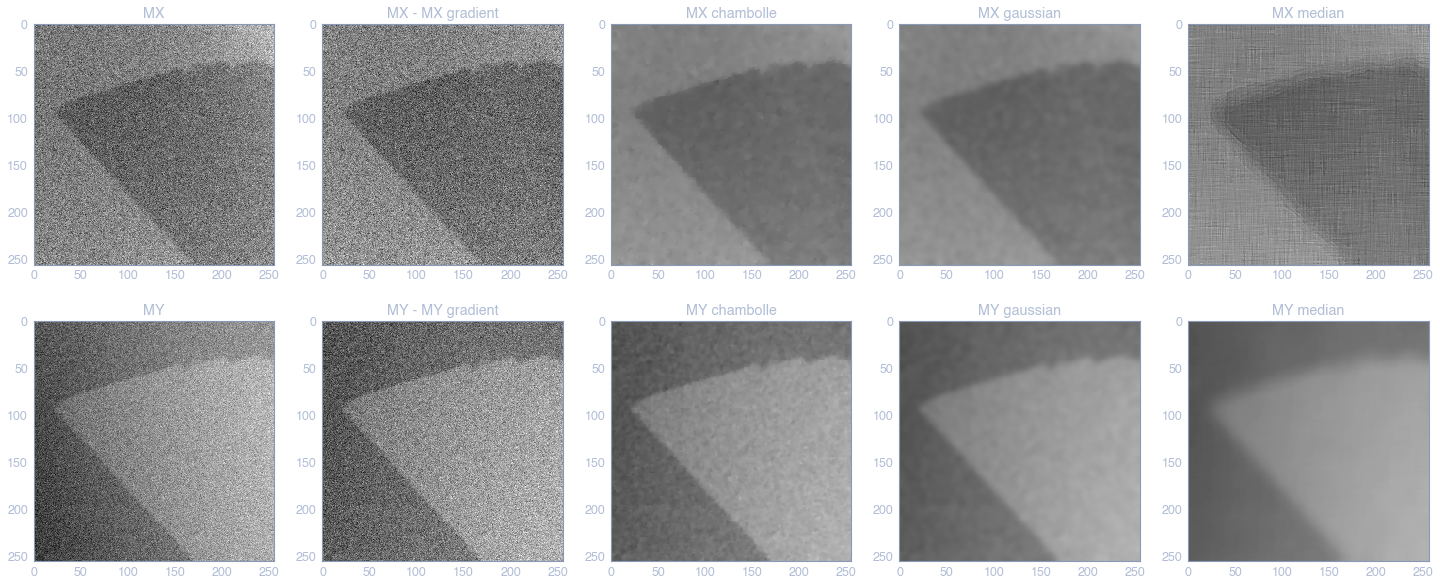

In [16]:
# See what that did

ncols = 5;
nrows = 2;
i = 1;

plt.figure(figsize=(ncols * 5, nrows * 5));

show_subplot_raw(ddx, nrows, ncols, i, 'MX'); i += 1;
show_subplot_raw(ddx_flat, nrows, ncols, i, 'MX - MX gradient'); i += 1;
show_subplot(ddx_denoised_chambolle, nrows, ncols, i, 'MX chambolle', vmin=np.min(ddx_flat), vmax=np.max(ddx_flat)); i += 1;
show_subplot(ddx_denoised, nrows, ncols, i, 'MX gaussian', vmin=np.min(ddx_flat), vmax=np.max(ddx_flat)); i += 1;
show_subplot(ddx_denoised_median, nrows, ncols, i, 'MX median', vmin=np.min(ddx_flat), vmax=np.max(ddx_flat)); i += 1;

show_subplot_raw(ddy, nrows, ncols, i, 'MY'); i += 1;
show_subplot_raw(ddy_flat, nrows, ncols, i, 'MY - MY gradient'); i += 1;
show_subplot(ddy_denoised_chambolle, nrows, ncols, i, 'MY chambolle', vmin=np.min(ddy_flat), vmax=np.max(ddy_flat)); i += 1;
show_subplot(ddy_denoised, nrows, ncols, i, 'MY gaussian', vmin=np.min(ddy_flat), vmax=np.max(ddy_flat)); i += 1;
show_subplot(ddy_denoised_median, nrows, ncols, i, 'MY median', vmin=np.min(ddy_flat), vmax=np.max(ddy_flat)); i += 1;

print('MX values   - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddx.min(), ddx.max(), np.ptp(ddx)))
print('MX flat     - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddx_flat.min(), ddx_flat.max(), np.ptp(ddx_flat)))
print('MX gaussian - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddx_denoised.min(), ddx_denoised.max(), np.ptp(ddx_denoised)))
print('MX median   - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddx_denoised_median.min(), ddx_denoised_median.max(), np.ptp(ddx_denoised_median)))
print()
print('MY values   - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddy.min(), ddy.max(), np.ptp(ddy)))
print('MY flat     - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddy_flat.min(), ddy_flat.max(), np.ptp(ddy_flat)))
print('MY gaussian - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddy_denoised.min(), ddy_denoised.max(), np.ptp(ddy_denoised)))
print('MY median   - min: {:.2f}, max: {:.2f}, PtP: {:.2f}'.format(ddy_denoised_median.min(), ddy_denoised_median.max(), np.ptp(ddy_denoised_median)))

### Masks

X threshold:  9.382233914286125e-05 , Y threshold:  -0.015801131755804717
X low:  -0.09328331858324554 , X high:  0.08482527858153023
Y low:  -0.07852451412002028 , Y high:  0.02964248484446723


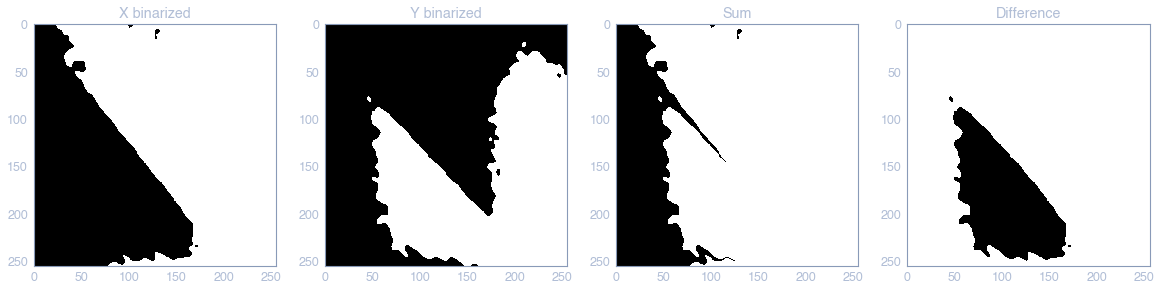

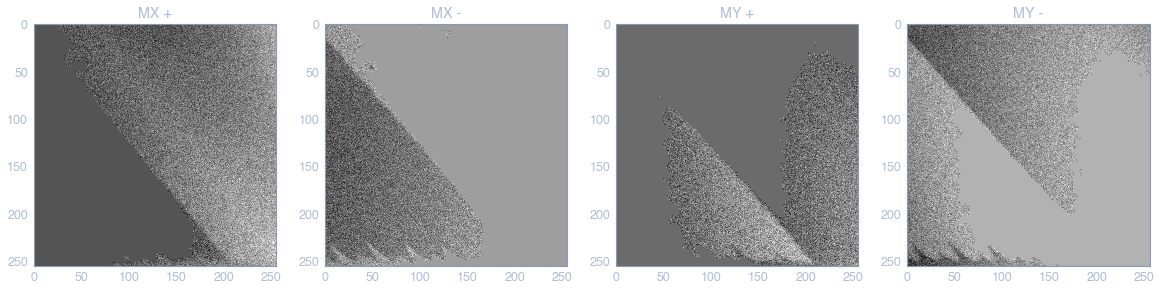

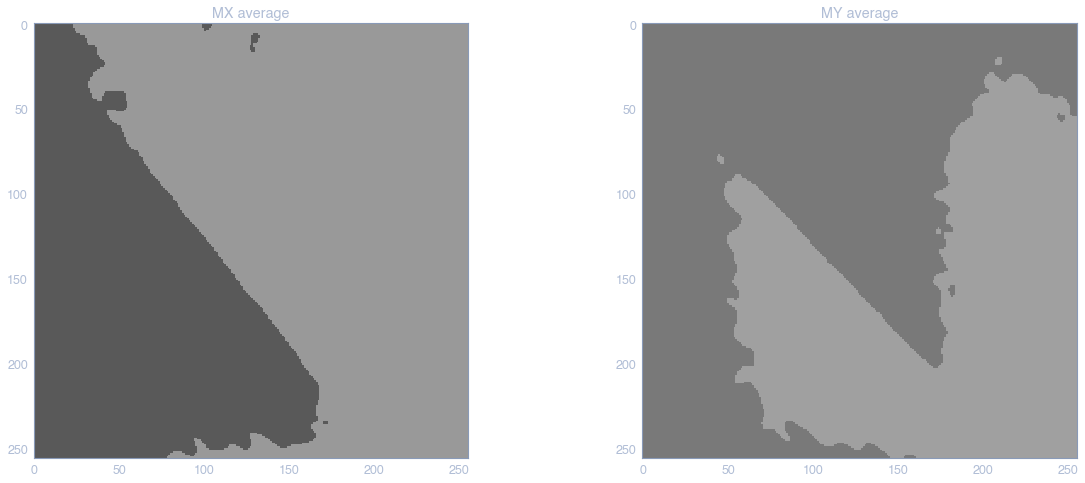

In [43]:
# Segment the denoised contrast images
# Based on code at https://www.degeneratestate.org/posts/2016/Oct/23/image-processing-with-numpy/

im_x = ddx_denoised
im_y = ddy_denoised

# x_threshold = np.average(find_segments(im_x))
# y_threshold = np.average(find_segments(im_y))

x_peaks, x_threshold = find_weighted_average(im_x)
y_peaks, y_threshold = find_weighted_average(im_y)

print('X threshold: ', x_threshold, ', Y threshold: ', y_threshold)

x_binary = im_x > x_threshold
y_binary = im_y > y_threshold

plt.figure(figsize=(20, 8));
show_subplot_raw(x_binary, 1, 4, 1, 'X binarized');
show_subplot_raw(y_binary, 1, 4, 2, 'Y binarized');
show_subplot_raw(x_binary + y_binary, 1, 4, 3, 'Sum');
show_subplot_raw(x_binary + ~y_binary, 1, 4, 4, 'Difference');

x_mask1, x_mask2 = ddx_flat * x_binary, ddx_flat * ~x_binary
y_mask1, y_mask2 = ddy_flat * y_binary, ddy_flat * ~y_binary

plt.figure(figsize=(20, 8));
show_subplot_raw(x_mask1, 1, 4, 1, 'MX +');
show_subplot_raw(x_mask2, 1, 4, 2, 'MX -');
show_subplot_raw(y_mask1, 1, 4, 3, 'MY +');
show_subplot_raw(y_mask2, 1, 4, 4, 'MY -');

ddx_avg_mask = average_from_masks(x_mask1, x_mask2, x_binary)
ddy_avg_mask = average_from_masks(y_mask1, y_mask2, y_binary)

print('X low: ', np.min(ddx_avg_mask), ', X high: ', np.max(ddx_avg_mask))
print('Y low: ', np.min(ddy_avg_mask), ', Y high: ', np.max(ddy_avg_mask))

plt.figure(figsize=(20, 8));
show_subplot(ddx_avg_mask, 1, 2, 1, 'MX average', vmin=np.min(ddx_flat), vmax=np.max(ddx_flat));
show_subplot(ddy_avg_mask, 1, 2, 2, 'MY average', vmin=np.min(ddy_flat), vmax=np.max(ddy_flat));

### Vector plots

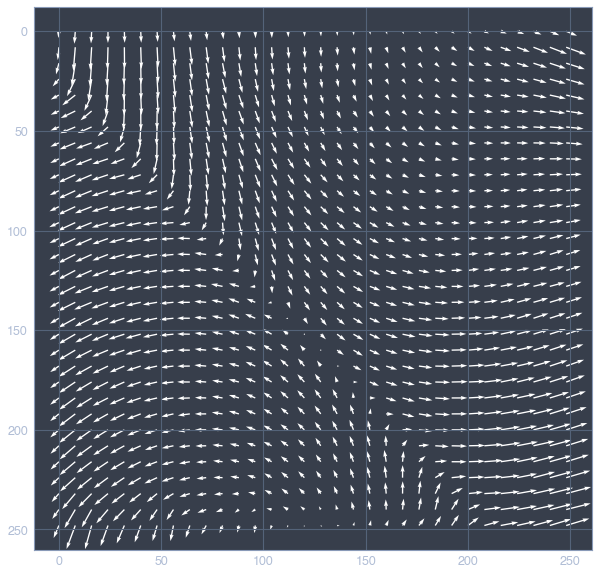

In [44]:
# Create a vector plot of the domains

fig = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
show_vector_plot(ddx_denoised, ddy_denoised, ax);
ax.set_ylim(ax.get_ylim()[::-1]);

### Extract contrast and phase

In [45]:
# Set up the colormap
cmap = create_ciecam02_cmap();

In [17]:
# Use x and y values to determine phase
contrast = get_contrast(ddx_denoised, ddy_denoised)

print(np.min(contrast), np.max(contrast), np.ptp(contrast), sep=', ')

0.01083179228537547, 6.278846045730003, 6.268014253444627


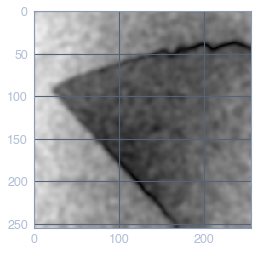

In [18]:
# Use x and y values to determine magnitude

phase_intensities = get_phase_intensities(ddx_denoised, ddy_denoised)

plt.imshow(phase_intensities, cmap='gray');

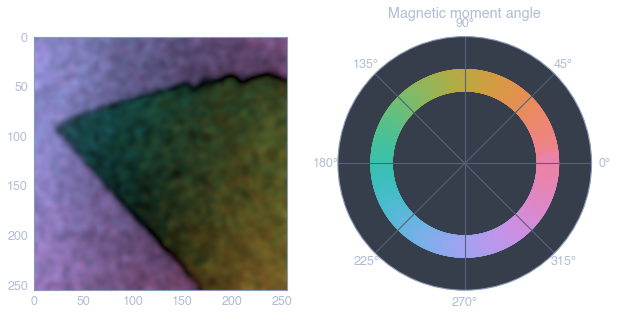

In [19]:
im = combine_phase_and_contrast(phase_intensities, contrast)

fig = plt.figure(figsize=(10, 6));
ax1 = plt.subplot(1, 2, 1);
ax2 = plt.subplot(1, 2, 2, polar=True);

ax1.imshow(im);
ax1.grid(False);
show_phase_colors_circle(ax2);
ax2.set_title('Magnetic moment angle');

### Color gradient

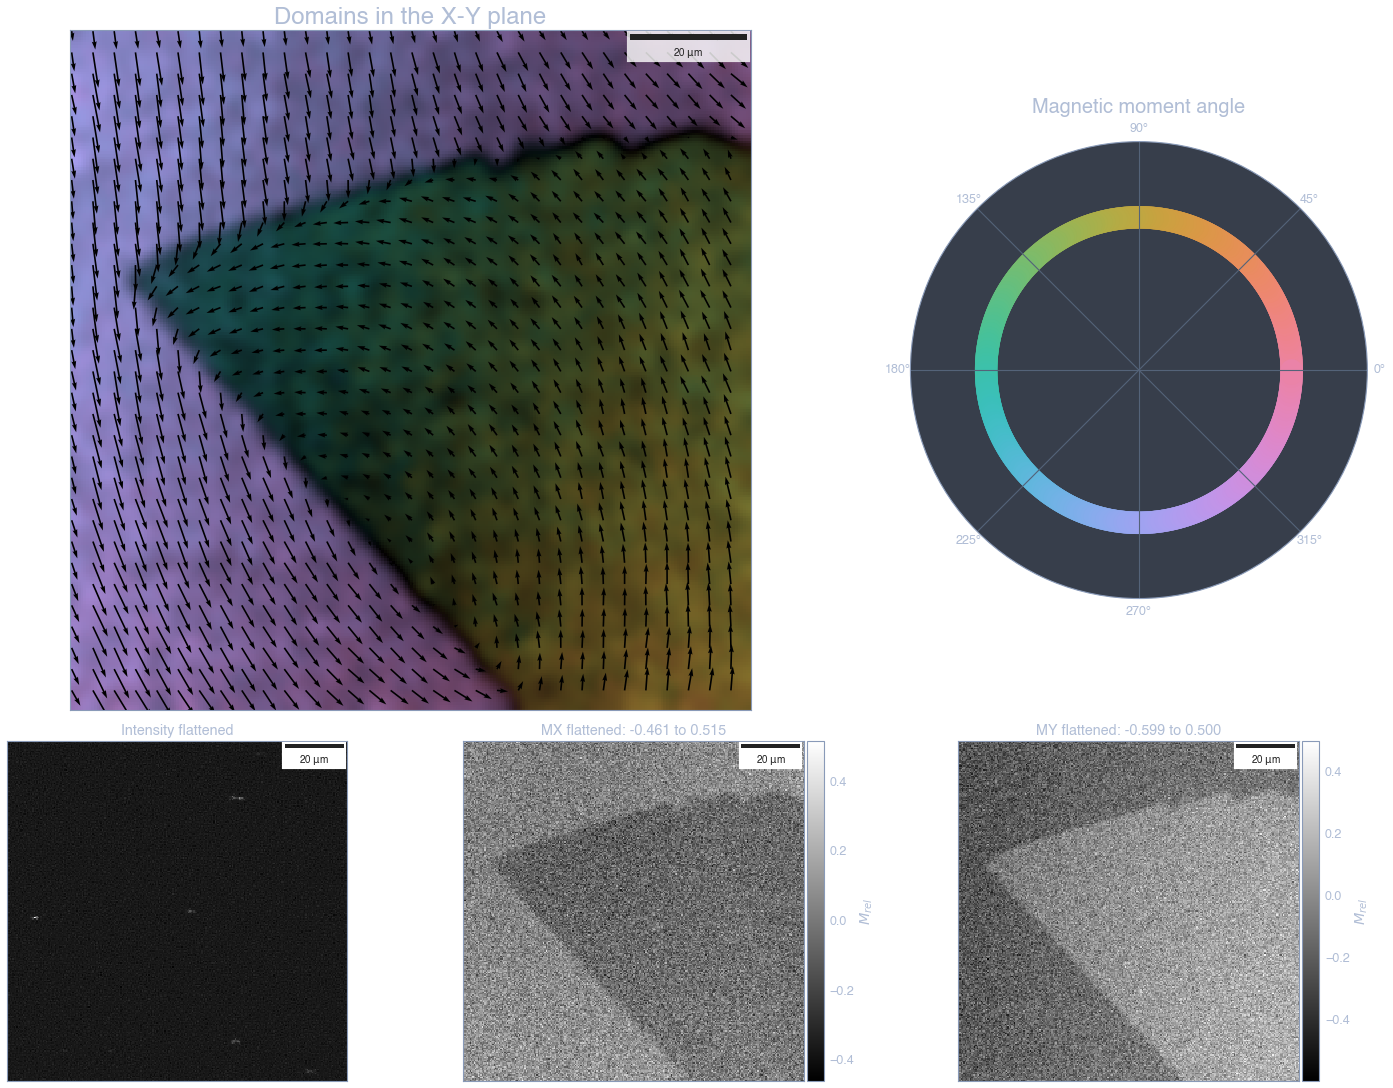

In [47]:
# Show a colorized version of the domains

im = combine_phase_and_contrast(phase_intensities, contrast)

fig = plt.figure(figsize=(20, 15), constrained_layout=True);

gs = fig.add_gridspec(3, 3)
gs.update(wspace = 0.3, hspace = 0.3)

# Contrast image
ax1 = plt.subplot(gs[:-1, :-1]);
ax1.imshow(im);
show_vector_plot(ddx_denoised, ddy_denoised, ax=ax1, color='black', scale=1.5)
ax1.add_artist(ScaleBar(scale, box_alpha=0.8));
ax1.set_title('Domains in the X-Y plane', fontdict={'fontsize': 24})

# Vector legend
ax2 = plt.subplot(gs[:-1, -1], polar=True);
show_phase_colors_circle(ax2);
ax2.set_title('Magnetic moment angle', fontdict={'fontsize': 20})

# Flattened intensity
ax3 = plt.subplot(gs[-1, 0]);
ax3.imshow(ddt_flat2, cmap='gray');
ax3.add_artist(ScaleBar(scale));
ax3.set_title('Intensity flattened');

# Flattened MX
ax4 = plt.subplot(gs[-1, 1]);
ax4.imshow(ddx_flat, cmap='gray');
ax4.add_artist(ScaleBar(scale));
ax4.set_title('MX flattened: {:.3f} to {:.3f}'.format(ddx_flat.min(), ddx_flat.max()));

# Add a colorbar
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddx_flat.min(), ddx_flat.max()))
divider = make_axes_locatable(ax4);
cax = divider.append_axes('right', size='5%', pad=0.05);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label(r'$M_{rel}$')

# Flattened MY
ax5 = plt.subplot(gs[-1, -1]);
ax5.imshow(ddy_flat, cmap='gray');
ax5.add_artist(ScaleBar(scale));
ax5.set_title('MY flattened: {:.3f} to {:.3f}'.format(ddy_flat.min(), ddy_flat.max()));

# Add a colorbar
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddy_flat.min(), ddy_flat.max()))
divider = make_axes_locatable(ax5);
cax = divider.append_axes('right', size='5%', pad=0.05);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label(r'$M_{rel}$')

# Turn off grids and axes except for the legend plot
for ax in fig.get_axes():
    if len(ax.images) > 0:
        ax.grid(False);
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

## Experimental

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


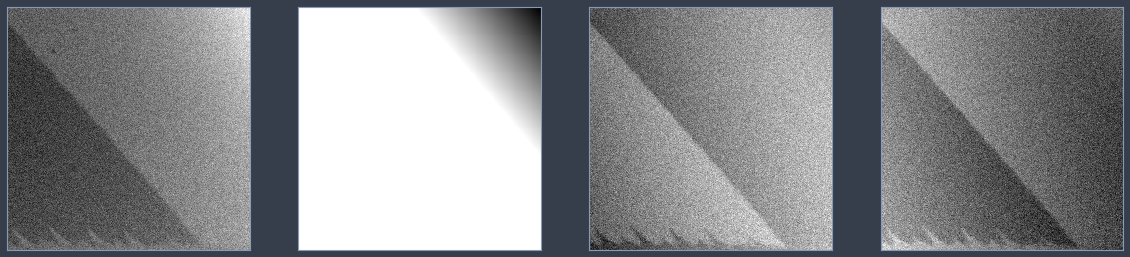

In [180]:
opacity = 0.01

alpha = np.ones_like(ddx)

nddx = normalize(ddy)
ddx_img = np.stack((nddx, nddx, nddx, alpha), axis=-1)
ddx_g = create_gradient(nddx, 0, -0.5, 0.65, 40)
#ddx_g = create_gradient(ddy, 0, -0.65, 0.3, 35)

ddx_g_i = ddx_g #util.invert(ddx_g)
ddx_g_img = np.stack((ddx_g_i, ddx_g_i, ddx_g_i, alpha), axis=-1)
ddx_blended = blend_modes.hard_light(ddx_img, ddx_g_img, opacity)
ddx_blended_scaled = scale_from_to(ddx_blended[:,:,0], ddx)

fig = plt.figure(figsize=(20, 10));
plt.gray();
ax1 = plt.subplot(1, 4, 1);
ax2 = plt.subplot(1, 4, 2);
ax3 = plt.subplot(1, 4, 3);
ax4 = plt.subplot(1, 4, 4);

ax1.imshow(ddx);
ax2.imshow(ddx_g);
ax3.imshow(ddx_blended);
ax4.imshow(util.invert(ddx_blended_scaled));

for ax in fig.get_axes():
    ax.grid(False);
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

Raw, 0.79860437, 1.6662564, 0.86765206
Blended, 0.0, 1.0, 1.0
Scaled, 0.79860437, 1.6662564, 0.86765206


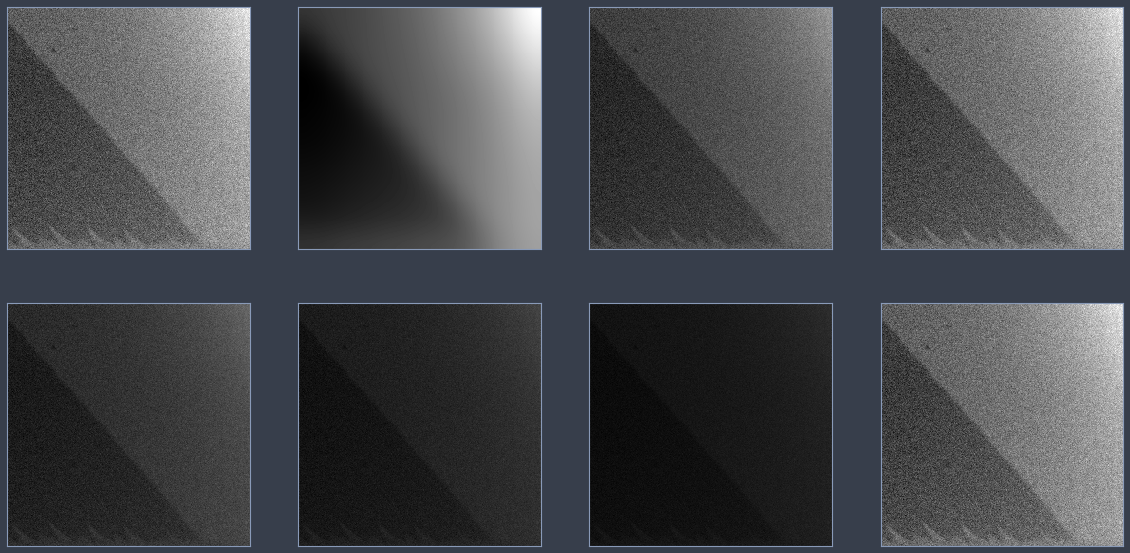

In [160]:
sigma, opacity = 16, 0.5

alpha = np.ones_like(ddx)

nddx = normalize(ddx)
ddx_img = np.stack((nddx, nddx, nddx, alpha), axis=-1)
ddx_g = gaussian_filter(nddx, sigma)
ddx_g_i = util.invert(ddx_g)
ddx_g_img = np.stack((ddx_g_i, ddx_g_i, ddx_g_i, alpha), axis=-1)
ddx_blended = blend_modes.hard_light(ddx_img, ddx_g_img, opacity)
ddx_blended_scaled = scale_from_to(ddx_blended[:,:,0], ddx)
ddx_blended2 = blend_modes.hard_light(ddx_blended, ddx_g_img, opacity)
ddx_blended3 = blend_modes.hard_light(ddx_blended2, ddx_g_img, opacity)
ddx_blended4 = blend_modes.hard_light(ddx_blended3, ddx_g_img, opacity)
ddx_blended4_scaled = scale_from_to(ddx_blended4[:,:,0], ddx)

print('Raw', ddx.min(), ddx.max(), np.ptp(ddx), sep=', ')
print('Blended', ddx_blended.min(), ddx_blended.max(), np.ptp(ddx_blended), sep=', ')
print('Scaled', ddx_blended_scaled.min(), ddx_blended_scaled.max(), np.ptp(ddx_blended_scaled), sep=', ')

fig = plt.figure(figsize=(20, 10));
plt.gray();
ax1 = plt.subplot(2, 4, 1);
ax2 = plt.subplot(2, 4, 2);
ax3 = plt.subplot(2, 4, 3);
ax4 = plt.subplot(2, 4, 4);
ax5 = plt.subplot(2, 4, 5);
ax6 = plt.subplot(2, 4, 6);
ax7 = plt.subplot(2, 4, 7);
ax8 = plt.subplot(2, 4, 8);

ax1.imshow(ddx);
ax2.imshow(ddx_g);
ax3.imshow(ddx_blended);
ax4.imshow(ddx_blended_scaled);
ax5.imshow(ddx_blended2);
ax6.imshow(ddx_blended3);
ax7.imshow(ddx_blended4);
ax8.imshow(ddx_blended4_scaled);

for ax in fig.get_axes():
    ax.grid(False);
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

In [ ]:
ncols = 5;
nrows = 1;
i = 1;

plt.figure(figsize=(ncols * 5, nrows * 5));

g = create_gradient(ddx) * 256;
gimg = Image.fromarray(g).convert('L');
#g = np.ones(ddx.shape)
plt.subplot(1, ncols, i); i += 1;
plt.imshow(g, vmin=0, vmax=255);
plt.grid(b=None);
plt.title('Gradient')

vals = np.rot90(np.ones(contrast.shape) * range(g.shape[0]))

s = Image.fromarray(vals).convert('L')
b = Image.fromarray(np.ones(contrast.shape) * 127).convert('L')

plt.subplot(1, ncols, i); i += 1;
plt.imshow(s, vmin=0, vmax=255);
plt.grid(b=None);
plt.title('Saturation')

img = Image.merge('HSV', (gimg, s, b))

plt.subplot(1, ncols, i); i += 1;
plt.imshow(img);
plt.grid(b=None);
plt.xlabel('Hue');
plt.ylabel('Saturation')
plt.title('HSV of gradient\n& saturation')

gimg_red = Image.fromarray(np.ones((256, 256)) * 255).convert('L');
img_red_grad = Image.merge('HSV', (gimg_red, s, b));

plt.subplot(1, ncols, i); i += 1;
plt.imshow(img_red_grad);
plt.grid(b=None);
plt.title('Red + saturation')

plt.subplot(1, ncols, i); i += 1;
plt.imshow(Image.merge('HSV', (gimg_red, b, b)));
plt.grid(b=None);
plt.title('Red + saturation');

In [ ]:
plt.figure(figsize=(20, 5))
show_subplot_raw(sobel(ddx), 1, 4, 1, 'MX')
show_subplot_raw(sobel(ddx_flat), 1, 4, 2, 'MX flat')
show_subplot_raw(sobel(ddx_denoised), 1, 4, 3, 'MX blurred')
show_subplot_raw(sobel(ddx_denoised_median), 1, 4, 4, 'MX median')

In [ ]:
ddx_denoised_chambolle = restoration.denoise_tv_chambolle(ddx_flat, weight=0.1);

plt.figure(figsize=(20,8))
show_subplot(ddx_flat, 1, 4, 1, 'MX')
show_subplot(ddx_denoised_chambolle, 1, 4, 2, 'Chambolle');
show_subplot(ddx_denoised, 1, 4, 3, 'Gaussian');
show_subplot(ddx_denoised_median, 1, 4, 4, 'Median');

In [ ]:
plt.imshow(create_gradient(ddx, 1, 10));
plt.grid(b=None)
print(create_gradient(ddx, 1, 10).shape)

In [ ]:
plt.imshow(rotate(create_gradient(ddx, 1, 0), 45));
plt.grid(b=None)

In [ ]:
Image.fromarray(ddx_flat, 'L')

In [ ]:
plt.imshow(rotate(ddx, 45))

In [ ]:
alpha = Image.new('L', ddx.shape,0)
draw = ImageDraw.Draw(alpha)
draw.pieslice([0,0,ddx.shape[0],ddx.shape[0]],0,270,fill=128)
plt.imshow(rotate(alpha, 0))

In [ ]:
data = contrast
bins = 60

data_min = data.min()
step = np.ptp(data) / bins

# Segregate bright vs. dark
mask = (data > data.mean()).astype(float)
#mask += 0.1 * data
img = mask + 0.2 * np.random.randn(*mask.shape)

hist, bin_edges = np.histogram(img, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

In [ ]:
#plt.plot(bin_centers, hist);
plt.hist(contrast.ravel());

In [ ]:
hist, bins = np.histogram(ddx_denoised.ravel(), bins=100);
plt.plot(bins[:-1], hist);

In [ ]:
len([x for x in [(b, h) for h, b in zip(hist, bins) if h > 0]])

In [ ]:
peaks = find_peaks(hist, prominence=np.max(hist) / 5)[0]
vals = np.asarray([(b, h) for b, h in zip(bins[peaks], hist[peaks])])

In [ ]:
vals[:, 0] * vals[:, 1]

In [ ]:
find_weighted_average(ddx_denoised)

In [ ]:
plt.figure(figsize=(10, 5));
plt.hist(ddx.ravel(), bins=50, label='MX');
plt.hist(ddx_flat.ravel(), bins=50, label="MX flat", alpha=0.5);
plt.xlabel('Value');
plt.ylabel('Count');
plt.xlim((0, 1));
plt.legend();

In [ ]:
show_subplot(ddx > 0.5, 1, 2, 1, 'MX')
show_subplot(ddx > 0.5, 1, 2, 2, 'MX flat')

In [ ]:
ddx_threshold = filters.threshold_sauvola(ddx_flat, window_size=25, k=0.3) #otsu(ddx_flat, 9); #local(ddx, block_size=25, offset=0.1)
show_subplot_raw(ddx_flat > ddx_threshold)

In [ ]:
angle = 120
hs, ss = get_hue_and_saturation_values(np.asarray([[100]]))
show_color(hs[0][0], ss[0][0], 150)

In [ ]:
plt.imshow(contrast * 255 / 360, cmap='hsv', vmin=0, vmax=255);

In [ ]:
contrast * 255/360

In [ ]:
purple = np.ones((100, 100)) * 144
plt.imshow(purple, cmap='hsv', vmin=0, vmax=255);
plt.grid(b=None);

In [ ]:
np.unique(contrast)

In [ ]:
plt.hist(ddx_flat);

In [ ]:
plt.hist(ddx);

In [ ]:
plt.hist(contrast);

In [ ]:
fig = plt.figure(figsize=(20, 30));

ax1 = fig.add_subplot(3, 2, 1);
ax2 = fig.add_subplot(3, 2, 2);
ax3 = fig.add_subplot(3, 2, 3);
ax4 = fig.add_subplot(3, 2, 4);
ax5 = fig.add_subplot(3, 2, 5);

ax1.imshow(ddx_flat);

ddx_flat_fft = np.fft.fft2(ddx_flat);
ax2.imshow(np.abs(ddx_flat_fft));

ddx_flat_ffts = np.fft.fftshift(ddx_flat_fft);
ax3.imshow(np.abs(ddx_flat_ffts));

sigmax, sigmay = 5, 5;
cx, cy = xd / 2, yd / 2;
x = np.linspace(0, xd, xd)
y = np.linspace(0, yd, yd)
X, Y = np.meshgrid(x, y)

gauss_mask = np.exp(-((X - cx) / sigmax)**2 - ((Y - cy) / sigmay)**2)
ddx_flat_gmask = ddx_flat_ffts * gauss_mask

ax4.imshow(np.abs(ddx_flat_gmask));

ddx_flat_gauss = np.fft.ifft2(ddx_flat_gmask);
ax5.imshow(np.abs(ddx_flat_gauss), vmin=np.min(ddx_flat), vmax=np.max(ddx_flat));

In [71]:
(ddx.min(), ddx.max(), np.ptp(ddx))

(0.64225286, 1.6741459, 1.031893)

In [ ]:
kernel = np.ones((9, 9))
kernel[4, 4] = 0

ddx_conv_sum = convolve2d(ddx_flat, kernel, mode='same')
ddx_conv_neighbors = convolve2d(np.ones(ddx_flat.shape), kernel, mode='same')
ddx_conv = ddx_conv_sum / ddx_conv_neighbors

print(ddx_flat.min(), ddx_flat.max(), sep=', ')
print(ddx_conv.min(), ddx_conv.max(), sep=', ')

plt.imshow(ddx_flat);
plt.figure();

plt.imshow(ddx_conv, vmin=np.min(ddx_flat), vmax=np.max(ddx_flat));

In [ ]:
image, name, dark, light, angle = ddx, 'MX', 1, 1, 10

kernel = np.ones((9, 9))
kernel[4, 4] = 0

xd, yd = image.shape
X = np.linspace(xd // 5, xd, 4, False, dtype='uint8')
Y = np.linspace(xd // 5, xd, 4, False, dtype='uint8')
x, y = np.meshgrid(X, Y)

plt.figure(figsize=(15, 5))

# Show the starting points
show_subplot_raw(ddx, 1, 2, 1, name + ' raw')
show_subplot_raw(create_gradient(ddx, 1, 1, angle), 1, 2, 2, name + ' gradient at {:.1f}°'.format(angle))

fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i in range(5):
    d = 1 + (dark + i) / 10

    for j in range(5):
        ax = axs[i, j]
        l = 1 + (light + j) / 10
        im = image - create_gradient(image, d, l, angle)

        show_subplot_raw(im, ax=ax);
        ax.set_title('Dark: {:.2f}, Light: {:.2f}'.format(d, l))

        # Show average values around a grid of points
        vals = convolve2d(im, kernel, mode='same') / convolve2d(np.ones(im.shape), kernel, mode='same');
        ax.plot(x.ravel(), y.ravel(), 'ro')
        #[ax.annotate('{:.2f}'.format(vals[x, y]), (x, y), textcoords='offset points', xytext=(0, 10)) for x, y in zip(x.ravel(), y.ravel())]
        #[ax.text(x, y, '{:.2f}'.format(vals[x, y]), fontsize=14, color='black') for x, y in zippy]


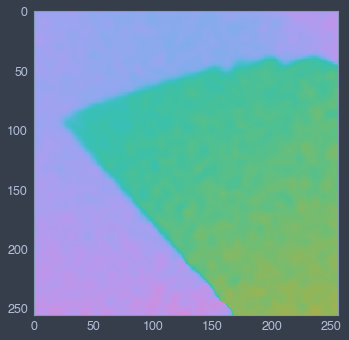

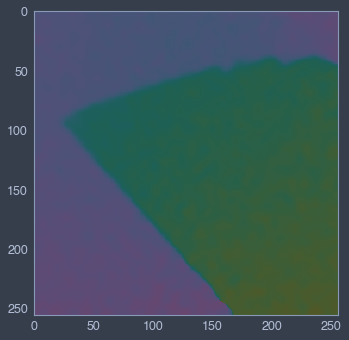

In [72]:
im = cmap(contrast / (2 * np.pi))
plt.imshow(im);
plt.grid(b=None);
#im[:,:,0] = im[:,:,0] * 0.5
plt.figure();
plt.imshow(im[:,:,:3] * 0.5);
plt.grid(b=None);
#im[:,:,:3]

## End